# Adjust index returns for inflation to get real returns

In [5]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
wb <- WorldBank()
indices <- Indices()

### get rate of inflation from the WorldBank data-set

In [2]:
# see example: https://nbviewer.jupyter.org/github/shyams80/plutons/blob/master/docs-R/WorldBank.ipynb

wb$Meta() %>%
    filter(COUNTRY_NAME == "India" & INDICATOR_NAME %like% "CPI%") %>%
    select(INDICATOR_NAME, COUNTRY_KEY, INDICATOR_KEY) %>%
    print(n=Inf)

# Source:   lazy query [?? x 3]
# Database: NORWAY:StockVizUs:R
  INDICATOR_NAME                          COUNTRY_KEY INDICATOR_KEY
  <chr>                                         <int>         <int>
1 CPI Price, nominal                              135             3
2 CPI Price, nominal, seas. adj.                  135             5
3 CPI Price, % y-o-y, nominal, seas. adj.         135             6


In [3]:
# we need the CPI Price, % y-o-y, nominal, seas. adj.
cpiInflation <- wb$TimeSeries() %>%
    filter(COUNTRY_KEY == 135 & INDICATOR_KEY == 6) %>%
    select(YEAR, VALUE) %>%
    collect() %>%
    arrange(YEAR) %>%
    as.data.frame()

print(cpiInflation)

   YEAR   VALUE
1  1987  8.7938
2  1988  9.3960
3  1989  3.2747
4  1990  8.9651
5  1991 13.8644
6  1992 11.7933
7  1993  6.3642
8  1994  6.3400
9  1995 11.3395
10 1996  8.8972
11 1997  5.6487
12 1998  4.4739
13 1999  5.9058
14 2000  5.9895
15 2001  3.6844
16 2002  5.2034
17 2003  4.3249
18 2004  3.8532
19 2005  3.7438
20 2006  6.0617
21 2007  5.9915
22 2008  8.5729
23 2009  9.7268
24 2010 10.3605
25 2011  8.3140
26 2012  9.3823
27 2013 10.1005
28 2014  6.4232
29 2015  4.9105
30 2016  4.9489
31 2017  3.3259
32 2018  3.3429
33 2019  2.3848


### get NIFTY 50 total-return index returns from the Indices data-set

In [6]:
#indexName <- 'NIFTY 50 TR'
indexName <- 'NIFTY GS 10YR'
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

annRets <- 100*annualReturn(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP))

df1 <- data.frame(annRets)
df1$YEAR <- year(index(annRets))

print(df1)

           yearly.returns YEAR
2000-12-31     12.7234788 2000
2001-12-31     28.4343077 2001
2002-12-31     22.7726472 2002
2003-12-31     12.9991159 2003
2004-12-31     -4.4660493 2004
2005-12-31      3.6987809 2005
2006-12-31      4.9029635 2006
2007-12-31      6.9582603 2007
2008-12-31     26.5762023 2008
2009-12-31    -12.1554113 2009
2010-12-31      3.9777091 2010
2011-12-31      2.9402665 2011
2012-12-31     10.8017180 2012
2013-12-31     -0.7892757 2013
2014-12-31     14.5907567 2014
2015-12-31      7.2566058 2015
2016-12-30     15.0318261 2016
2017-12-29      0.3356249 2017
2018-12-31      6.2430053 2018
2019-09-24      7.2666304 2019


In [7]:
# merge the two

allData <- merge(df1, cpiInflation, by='YEAR')
names(allData) <- c('YEAR', 'INDEX', 'INFLATION')
allData$REAL <- allData$INDEX - allData$INFLATION
print(allData)

   YEAR       INDEX INFLATION         REAL
1  2000  12.7234788    5.9895   6.73397880
2  2001  28.4343077    3.6844  24.74990765
3  2002  22.7726472    5.2034  17.56924720
4  2003  12.9991159    4.3249   8.67421590
5  2004  -4.4660493    3.8532  -8.31924930
6  2005   3.6987809    3.7438  -0.04501905
7  2006   4.9029635    6.0617  -1.15873647
8  2007   6.9582603    5.9915   0.96676031
9  2008  26.5762023    8.5729  18.00330234
10 2009 -12.1554113    9.7268 -21.88221132
11 2010   3.9777091   10.3605  -6.38279094
12 2011   2.9402665    8.3140  -5.37373352
13 2012  10.8017180    9.3823   1.41941804
14 2013  -0.7892757   10.1005 -10.88977565
15 2014  14.5907567    6.4232   8.16755675
16 2015   7.2566058    4.9105   2.34610584
17 2016  15.0318261    4.9489  10.08292611
18 2017   0.3356249    3.3259  -2.99027510
19 2018   6.2430053    3.3429   2.90010530
20 2019   7.2666304    2.3848   4.88183038


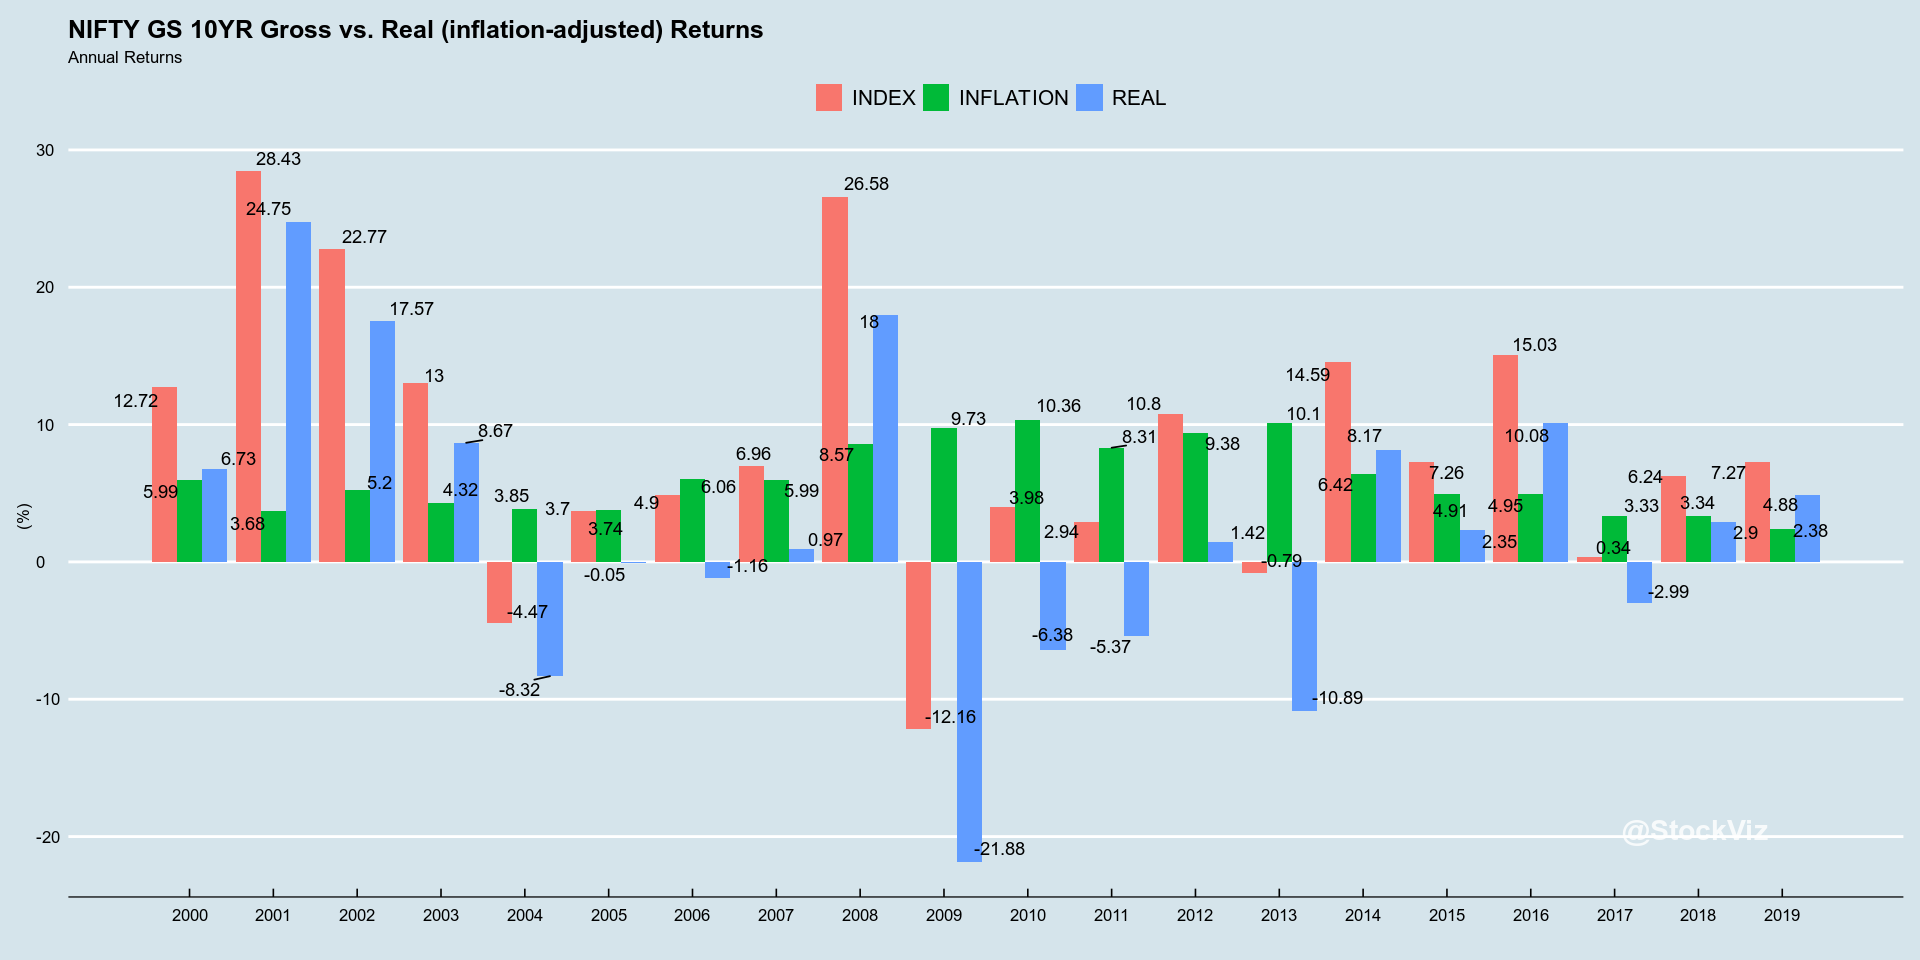

In [8]:
# plot the data

mDf <- melt(allData, id='YEAR')
ggplot(mDf, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=allData$YEAR, breaks=allData$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("%s Gross vs. Real (inflation-adjusted) Returns", indexName), 
         subtitle="Annual Returns") +
    annotate("text", x=max(allData$YEAR), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [9]:
### calculate rolling inflation adjusted retuns
rYr <- 10 #years

#cumulative
rollingRets <- 100*rollapply(allData$REAL/100, rYr, Return.cumulative)
print(sprintf("%d-year rolling returns (not annualized):", rYr))
print(rollingRets)
print("Stats:")
print(summary(rollingRets))

[1] "10-year rolling returns (not annualized):"
 [1]  43.418970  25.793902  -4.581835 -17.688894 -32.506887 -20.369706
 [7] -18.464789  -9.191421 -12.750343 -23.917393   2.149373
[1] "Stats:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-32.507 -19.417 -12.750  -6.192  -1.216  43.419 


In [10]:
#annualzied

annRollingRets <- (1+rollingRets/100)^(1/rYr) - 1
annRollingRets <- 100* annRollingRets

print(sprintf("%d-year rolling annualized returns:", rYr))
print(annRollingRets)
print("Stats:")
print(summary(annRollingRets))

[1] "10-year rolling annualized returns:"
 [1]  3.6718050  2.3212787 -0.4679140 -1.9278167 -3.8551678 -2.2520109
 [7] -2.0206576 -0.9595311 -1.3547057 -2.6964828  0.2128862
[1] "Stats:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.8552 -2.1363 -1.3547 -0.8480 -0.1275  3.6718 


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)